In [2]:
import json
from tqdm import tqdm
import uuid
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data



In [ ]:
data  = load_json("/home/omote/local-share-data_ssd/object365/raw_data/zhiyuan_objv2_train.json")

In [ ]:
images = data["images"]
annotations = data["annotations"]
categories = data["categories"]


In [ ]:
categories_dict = {}
for category in categories:
    categories_dict[category["id"]] = category["name"]

In [ ]:
print(categories_dict)

In [ ]:
new_json_data = []
annotation_index = 0
for i, image_info in tqdm(enumerate(images)):
    image_id = image_info["id"]
    file_name = image_info["file_name"]
    width = image_info["width"]
    height = image_info["height"]
    annotation_list = []
    for annotation in annotations[annotation_index:]:
        if annotation["image_id"] == image_id:
            category_id = annotation["category_id"]
            category_name = categories_dict[category_id]
            bbox = annotation["bbox"]
            iscrowd = annotation["iscrowd"]
            isfake = annotation["isfake"]
            annotation_list.append({
                "category": category_name,
                "bbox": bbox,
                "iscrowd": iscrowd,
                "isfake": isfake,
            })
            annotation_index += 1
        else:
            break
    new_json_data.append({
        "image_id": image_id,
        "file_name": file_name,
        "width": width,
        "height": height,
        "annotations": annotation_list,
    })
    if i == 1000:
        break

In [ ]:
print(len(new_json_data))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imgviz
def visualize_bbox(image, bbox_list, caption_list):
    bboxes = []
    labels = []
    label_id = -1
    old_label = None
    for bbox ,caption in zip(bbox_list, caption_list):
        x, y, w, h = bbox
        bboxes.append([y, x, y + h, x + w])
        if old_label != caption:
            label_id += 1
            old_label = caption
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    print(len(bboxes),len(caption_list))
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=caption_list,font_size=16)

    plt.imshow(image)
    plt.show()

In [ ]:
import os
from PIL import Image
data_index = 2
image_path = new_json_data[data_index]["file_name"]
tmp = image_path[image_path.find("patch"):]
image_path = os.path.join(tmp.split("/")[0],tmp)
bbox_list = []
caption_list = []
for annotation in new_json_data[data_index]["annotations"]:
    bbox_list.append(annotation["bbox"])
    caption_list.append(annotation["category"])
    
print(len(bbox_list))
print(len(caption_list))

In [ ]:
image_path = os.path.join("/home/omote/local-share-data_ssd//object365/raw_data/images/train",image_path)
print(image_path)
image = Image.open(image_path)

visualize_bbox(image, bbox_list, caption_list)

In [ ]:
def make_id():
    return str(uuid.uuid4())

def make_conversation(id,image_path,question,answer,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"<image>\n{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ]
    }
    return return_data


def make_question():
    return  f"Please output bbox coordinates and names of every item in this image."

def xywh_to_xyxy(bbox):
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[0] + bbox[2]
    y2 = bbox[1] + bbox[3]
    return [x1, y1, x2, y2]

def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def make_str_bbox(bbox, image_width_height):
    relative_bbox = bbox_absolute_to_relative(bbox, image_width_height)
    relative_bbox = [f"{coord:.3f}" for coord in relative_bbox]
    
    return f"[{relative_bbox[0]},{relative_bbox[1]},{relative_bbox[2]},{relative_bbox[3]}]"

def make_answer(image_width_height, bbox_list, caption_list):
    answer = []
    for bbox, caption in zip(bbox_list, caption_list):
        str_bbox = make_str_bbox(bbox, image_width_height)
        answer.append(f"{caption}: {str_bbox}")
    return "\n".join(answer)

In [ ]:
converted_data = []

for sample in tqdm(new_json_data):
    id = make_id()
    
    image_file_name = sample["file_name"]
    tmp = image_file_name[image_file_name.find("patch"):]
    image_path = os.path.join("objects365/train",tmp)
    
    original_image_width_height = (sample["width"], sample["height"])
    

    bbox_list = []
    caption_list = []
    for annotation in sample["annotations"]:
        bbox_list.append(xywh_to_xyxy(annotation["bbox"]))
        caption_list.append(annotation["category"])
    
    question = make_question()
    answer = make_answer(original_image_width_height,bbox_list, caption_list)
    conversation = make_conversation(id,image_path,question,answer)
    converted_data.append(conversation)


In [ ]:
print(converted_data[0])

In [ ]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image

def visualize_bbox(image, bbox_list, caption_list):
    bboxes = []
    labels = []
    label_id = -1
    old_label = None
    for bbox ,caption in zip(bbox_list, caption_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        if old_label != caption:
            label_id += 1
            old_label = caption
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    print(len(bboxes),len(caption_list))
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=16)

    plt.imshow(image)
    plt.show()
    
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox


image_folder_root = "/home/omote/local-share-data_ssd/object365/raw_data/images/train"
sample_data = converted_data[2]

image_path = sample_data["image"]
tmp = image_path[image_path.find("patch"):]
image_path = os.path.join(tmp.split("/")[0],tmp)
image_path = os.path.join(image_folder_root,image_path)
image = Image.open(image_path)
original_image_width_height = (image.width, image.height)

answer = sample_data["conversations"][1]["value"]
relative_bbox_list = extract_bbox_from_text(answer)
print(relative_bbox_list)
absolute_bbox_list = []
for relative_bbox in relative_bbox_list:
    absolute_bbox = bbox_relative_to_absolute(relative_bbox, original_image_width_height)
    absolute_bbox_list.append(absolute_bbox)

print(sample_data["conversations"][1]["value"])
visualize_bbox(image, absolute_bbox_list, sample_data["conversations"][1]["value"])


In [ ]:
print(len(data))
print(data.keys())

print(len(annotations))
print(annotations[0])

print(images[0])
print(len(images))
for key,value in data[0].items():
    print(key + " : " + str(value))


In [3]:
with open("/home/omote/local-share-data_ssd/object365/object365_train_conversation.json", "r") as f:
    loaded_data = json.load(f)
print("len(loaded_data):",len(loaded_data))

len(loaded_data): 1742292


In [ ]:
print(loaded_data[0])

In [18]:
import os
from copy import deepcopy
image_folder_root = "/home/omote/local-share-data_ssd"

exist_json_data = []
exist_image_count = 0
for i in tqdm(range(len(loaded_data))):
    image_file_name = loaded_data[i]["image"]
    image_file_name = "object365/raw_data/images/train/" + image_file_name.split("/")[2] + "/"+ image_file_name[image_file_name.find("patch"):]
    image_path = os.path.join(image_folder_root,image_file_name)
    if not os.path.exists(image_path):
        print(f"index: {i}")
        print(f"Image file does not exist: {image_path}")
        continue
    else:
        exist_image_count += 1
        exist_json_data.append(deepcopy(loaded_data[i]))
print("exist_image_count:", exist_image_count)
print("non_exist_image_count:", len(loaded_data) - exist_image_count)
print("exist_image_count / len(loaded_data):", exist_image_count / len(loaded_data))

  1%|          | 12356/1742292 [00:03<09:38, 2988.67it/s]

index: 11361
Image file does not exist: /home/omote/local-share-data_ssd/object365/raw_data/images/train/patch16/patch16/objects365_v2_00908726.jpg


 60%|██████    | 1050250/1742292 [03:29<02:16, 5086.25it/s]

index: 1049254
Image file does not exist: /home/omote/local-share-data_ssd/object365/raw_data/images/train/patch6/patch6/objects365_v1_00320532.jpg


 71%|███████   | 1239648/1742292 [04:06<01:38, 5105.37it/s]

index: 1238813
Image file does not exist: /home/omote/local-share-data_ssd/object365/raw_data/images/train/patch6/patch6/objects365_v1_00320534.jpg


100%|██████████| 1742292/1742292 [05:46<00:00, 5034.25it/s]

exist_image_count: 1742289
non_exist_image_count: 3
exist_image_count / len(loaded_data): 0.9999982781301872


In [21]:
print(len(exist_json_data))
with open("/home/omote/local-share-data_ssd/object365/object365_train_conversation_exist_image.json", "w") as f:
    json.dump(exist_json_data, f, indent=4)

1742289


In [22]:
print(exist_json_data[0])

{'id': '6d442788-032a-4e61-8d2b-6383b5e44fa5', 'image': 'objects365/train/patch8/objects365_v1_00420917.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nPlease output bbox coordinates and names of every item in this image.'}, {'from': 'gpt', 'value': 'Air Conditioner: [0.639,0.172,0.685,0.259]\nLamp: [0.386,0.110,0.405,0.305]\nLamp: [0.275,0.117,0.293,0.316]\nLamp: [0.187,0.067,0.198,0.113]\nLamp: [0.033,0.074,0.065,0.120]\nCabinet/shelf: [0.190,0.247,0.268,0.393]\nCabinet/shelf: [0.266,0.293,0.318,0.402]\nPerson: [0.310,0.348,0.344,0.443]\nPerson: [0.333,0.335,0.373,0.439]\nPerson: [0.363,0.355,0.412,0.437]\nHat: [0.336,0.337,0.360,0.363]\nHat: [0.378,0.356,0.396,0.369]\nBottle: [0.059,0.592,0.093,0.682]\nPlate: [0.195,0.620,0.237,0.644]\nBottle: [0.238,0.521,0.257,0.571]\nPlate: [0.305,0.550,0.332,0.561]\nBottle: [0.359,0.484,0.371,0.515]\nBottle: [0.333,0.484,0.345,0.515]\nPlate: [0.373,0.513,0.392,0.520]\nRefrigerator: [0.051,0.257,0.209,0.555]\nCoffee Machine: [0.405,0

[[0.143, 0.861, 0.98, 0.98], [0.033, 0.028, 0.848, 0.9], [0.102, 0.385, 0.148, 0.429], [0.13, 0.376, 0.172, 0.42], [0.655, 0.478, 0.711, 0.498], [0.398, 0.024, 0.626, 0.132], [0.462, 0.845, 0.656, 0.895], [0.682, 0.843, 0.848, 0.9]]
Skateboard: [0.143,0.861,0.980,0.980]
Person: [0.033,0.028,0.848,0.900]
Bracelet: [0.102,0.385,0.148,0.429]
Bracelet: [0.130,0.376,0.172,0.420]
Watch: [0.655,0.478,0.711,0.498]
Helmet: [0.398,0.024,0.626,0.132]
Sneakers: [0.462,0.845,0.656,0.895]
Sneakers: [0.682,0.843,0.848,0.900]
8 282


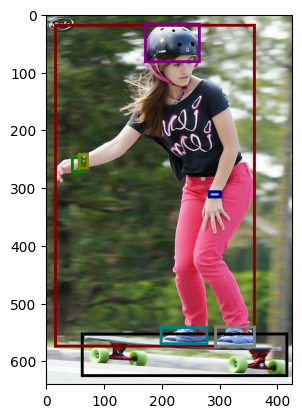

In [25]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image

def visualize_bbox(image, bbox_list, caption_list):
    bboxes = []
    labels = []
    label_id = -1
    old_label = None
    for bbox ,caption in zip(bbox_list, caption_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        if old_label != caption:
            label_id += 1
            old_label = caption
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    print(len(bboxes),len(caption_list))
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=16)

    plt.imshow(image)
    plt.show()
    
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox


image_folder_root = "/home/omote/local-share-data_ssd/llava-onevision-data-symbolic-link"
sample_data = exist_json_data[2]

image_path = sample_data["image"]
image_path = os.path.join(image_folder_root,image_path)
image = Image.open(image_path)
original_image_width_height = (image.width, image.height)

answer = sample_data["conversations"][1]["value"]
relative_bbox_list = extract_bbox_from_text(answer)
print(relative_bbox_list)
absolute_bbox_list = []
for relative_bbox in relative_bbox_list:
    absolute_bbox = bbox_relative_to_absolute(relative_bbox, original_image_width_height)
    absolute_bbox_list.append(absolute_bbox)

print(sample_data["conversations"][1]["value"])
visualize_bbox(image, absolute_bbox_list, sample_data["conversations"][1]["value"])